# Fire Damage Estimation

### Table of Contents<a id="toc"></a>

* [Introduction](#intro)
    * [First Steps](#setup)
* [Initial Exploration](#init_explore)
    * [Column Definitions](#col_deff)
* [Data Cleaning](#data_cleaning)
    * [Distributions](#distributions)
    * [Outliers](#outliers)
    * [Correlations](#correlations)
* [Deep Exploration](#deep_explore)
* [Model Building](#building)
* [Model Metrics and Evaluation](#model_eval)
* [Decision Tree Flow Diagram](#diagram)
* [Final Evaluation](#final_eval)
* [Conclusion](#conclusion)


[Back to Table of Contents](#toc)

### Introduction<a id="intro"></a>

In this project we will be working with a dataset containing information about forest fires in northeast Portugal. We are tasked with building a model that predicts the potentil amount of damage future forest fires may cause. Our goal in this project is to use various tequnics to optimize our model, to achive the highest predictive accuracy as possible.

### First Steps<a id="setup"></a>

As always, our first steps of any project are to import our libraries and upload our data.

In [1]:
# NOTE: Make sure to clean library selection at the end and remove any that did not get used

# importing libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

from sklearn.model_selection import cross_val_score 
from sklearn.decomposition import PCA

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
fires = pd.read_csv("fires.csv")

### Initial Exploration<a id="init_explore"></a>

With our project now prepared and ready, we can move into the initial exploration stage. This step provides us with an idea of the data we’re working with and helps us start our list of items we’ll need to clean up later.

In [3]:
fires

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.00
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.00
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.00
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.00
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,513,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32.0,2.7,0.0,6.44
513,514,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71.0,5.8,0.0,54.29
514,515,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70.0,6.7,0.0,11.16
515,516,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42.0,4.0,0.0,0.00


**`fires` – Observations:**

* Some column names appear to be shorthand for longer terms, so we need to confirm their full meanings.
* There are **517** rows and **14** columns.
* We can see a few categorical columns
* We also notice several empty or 'NaN' values

In [4]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


**`fires.info()` – Observations:**

* There are **2** object columns, **3** integer columns, and **9** float columns.
* As we suspected, there are lots of missing values

In [5]:
fires.describe()

,Unnamed: 0,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,469.000000,496.000000,474.000000,515.000000,496.000000,487.000000,482.000000,485.000000,517.000000
mean,259.000000,4.669246,4.299807,90.580384,111.195363,550.673418,9.018835,18.884677,44.381930,4.021784,0.023093,12.847292
std,149.389312,2.313778,1.229900,5.698137,64.008450,246.061309,4.564890,5.748318,16.180372,1.794460,0.305532,63.655818
min,1.000000,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,130.000000,3.000000,4.000000,90.200000,70.800000,441.200000,6.450000,15.475000,33.000000,2.700000,0.000000,0.000000
50%,259.000000,4.000000,4.000000,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,388.000000,7.000000,5.000000,92.800000,141.575000,713.900000,10.750000,22.725000,53.500000,4.900000,0.000000,6.570000
max,517.000000,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


**`fires.describe()` – Observations:**

* There do not appear to be any binary columns.

In [6]:
fires.columns

Index(['Unnamed: 0', 'X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI',
       'temp', 'RH', 'wind', 'rain', 'area'],
      dtype='object')

##### **Dataset Column Definitions**<a id="col_deff"></a>
*(Source: [UCI Machine Learning Repository – Forest Fires Dataset](https://archive.ics.uci.edu/dataset/162/forest+fires))*

1. **X** – X-axis spatial coordinate within the Montesinho Park map, ranging from 1 to 9.
2. **Y** – Y-axis spatial coordinate within the Montesinho Park map, ranging from 2 to 9.
3. **month** – Month in which the fire occurred, represented as abbreviations from `'jan'` to `'dec'`.
4. **day** – Day of the week on which the fire occurred, represented as abbreviations from `'mon'` to `'sun'`.
5. **FFMC** – Fine Fuel Moisture Code (FFMC) index from the Fire Weather Index (FWI) system, ranging from 18.7 to 96.20.
6. **DMC** – Duff Moisture Code (DMC) index from the FWI system, with values between 1.1 and 291.3.
7. **DC** – Drought Code (DC) index from the FWI system, ranging from 7.9 to 860.6.
8. **ISI** – Initial Spread Index (ISI) from the FWI system, ranging from 0.0 to 56.10.
9. **temp** – Air temperature measured in degrees Celsius, ranging from 2.2 to 33.30.
10. **RH** – Relative humidity expressed as a percentage, ranging from 15.0% to 100%.
11. **wind** – Wind speed measured in kilometers per hour (km/h), ranging from 0.40 to 9.40.
12. **rain** – Amount of outside rainfall measured in millimeters per square meter (mm/m²), ranging from 0.0 to 6.4.
13. **area** – Total burned forest area measured in hectares (ha).

You may notice that the `Unnamed: 0` column does not appear in the above definitions. This is because it is simply another indexing column that numbers the rows. It's values hold no significant value, and we will end up removing it from the dataset in the code below.

Now that we have explored our data, our first data cleaning action will be to convert our object datatype columns into numeric datatype. As we saw above, our object columns are the `month` and `day` column. We will convert these to numeric columns, by transforming them into dummy variables. Dummy variables convert the values of object columns into numbers by creating new columns for each unique value in the original column. In these new columns, a 1 indicates that the row belongs to that category, while a 0 indicates that it does not. This format makes the data easier for a computer to understand and use when building a model.

In [7]:
fires_clean = fires.copy()

# Drop the Unnamed: 0 column
fires_clean = fires_clean.drop(columns=['Unnamed: 0'])

# Convert the selected columns into dummy variables
month_dummies = pd.get_dummies(fires_clean['month'], prefix='month')
day_dummies = pd.get_dummies(fires_clean['day'], prefix='day')

# Joining the original df and the dummies df
fires_clean = pd.concat([fires_clean, month_dummies], axis=1)
fires_clean = pd.concat([fires_clean, day_dummies], axis=1)

# Drop all the original columns
fires_clean = fires_clean.drop(columns=['month'])
fires_clean = fires_clean.drop(columns=['day'])

# Convert all boolean columns (dummy variables) to integers (1 or 0)
fires_clean[fires_clean.select_dtypes(include='bool').columns] = fires_clean.select_dtypes(include='bool').astype(int)

In [8]:
# Reorganizing the columns
new_order = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', 'month_jan', 'month_feb', 'month_mar', 'month_apr', 'month_may', 'month_jun', 'month_jul', 'month_aug', 'month_sep', 'month_oct', 'month_nov', 'month_dec', 'day_mon', 'day_tue', 'day_wed', 'day_thu', 'day_fri', 'day_sat', 'day_sun']

fires_clean = fires_clean.reindex(columns=new_order)

In [9]:
fires_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          517 non-null    int64  
 1   Y          517 non-null    int64  
 2   FFMC       469 non-null    float64
 3   DMC        496 non-null    float64
 4   DC         474 non-null    float64
 5   ISI        515 non-null    float64
 6   temp       496 non-null    float64
 7   RH         487 non-null    float64
 8   wind       482 non-null    float64
 9   rain       485 non-null    float64
 10  area       517 non-null    float64
 11  month_jan  517 non-null    int64  
 12  month_feb  517 non-null    int64  
 13  month_mar  517 non-null    int64  
 14  month_apr  517 non-null    int64  
 15  month_may  517 non-null    int64  
 16  month_jun  517 non-null    int64  
 17  month_jul  517 non-null    int64  
 18  month_aug  517 non-null    int64  
 19  month_sep  517 non-null    int64  
 20  month_oct 

Now that we've taken care of our object columns, we will move to take care of our large assortment of missing values. We've decided to use the SimpleImputer class, with `median` as our strategy. This will replace all the empty values in each column with the median value for that column. 

We will do this in the code below:

In [10]:
error_columns = ['FFMC', 'DMC', 'DC', 'ISI',
       'temp', 'RH', 'wind', 'rain']

# Initialize the SimpleImputer
simple_imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
fires_clean[error_columns] = simple_imputer.fit_transform(fires_clean[error_columns])

# Convert imputed arrays back to DataFrames for better readability
fires_clean = pd.DataFrame(fires_clean, columns=fires_clean.columns)

In [11]:
fires_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          517 non-null    int64  
 1   Y          517 non-null    int64  
 2   FFMC       517 non-null    float64
 3   DMC        517 non-null    float64
 4   DC         517 non-null    float64
 5   ISI        517 non-null    float64
 6   temp       517 non-null    float64
 7   RH         517 non-null    float64
 8   wind       517 non-null    float64
 9   rain       517 non-null    float64
 10  area       517 non-null    float64
 11  month_jan  517 non-null    int64  
 12  month_feb  517 non-null    int64  
 13  month_mar  517 non-null    int64  
 14  month_apr  517 non-null    int64  
 15  month_may  517 non-null    int64  
 16  month_jun  517 non-null    int64  
 17  month_jul  517 non-null    int64  
 18  month_aug  517 non-null    int64  
 19  month_sep  517 non-null    int64  
 20  month_oct 

In [12]:
fires_clean.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_oct,month_nov,month_dec,day_mon,day_tue,day_wed,day_thu,day_fri,day_sat,day_sun
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.00000,517.000000,517.000000,...,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.580384,111.195363,550.673418,9.018835,18.884677,44.38193,4.021784,0.023093,...,0.029014,0.001934,0.017408,0.143133,0.123791,0.104449,0.117988,0.164410,0.162476,0.183752
std,2.313778,1.229900,5.426639,62.692424,235.585767,4.556035,5.630131,15.70297,1.732533,0.295907,...,0.168007,0.043980,0.130913,0.350548,0.329662,0.306138,0.322907,0.371006,0.369244,0.387657
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.00000,0.400000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,90.500000,73.400000,474.900000,6.500000,15.700000,33.00000,2.700000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,91.500000,109.200000,647.100000,8.400000,19.100000,43.00000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,5.000000,92.500000,141.200000,706.400000,10.700000,22.400000,53.00000,4.900000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.00000,9.400000,6.400000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Next, we would like to examine the distributions of our columns. In the code below, we will generate several bar graphs displaying the structure of our columns. We will split the dummy variable columns from the other columsn and examine both groups, in the code below.

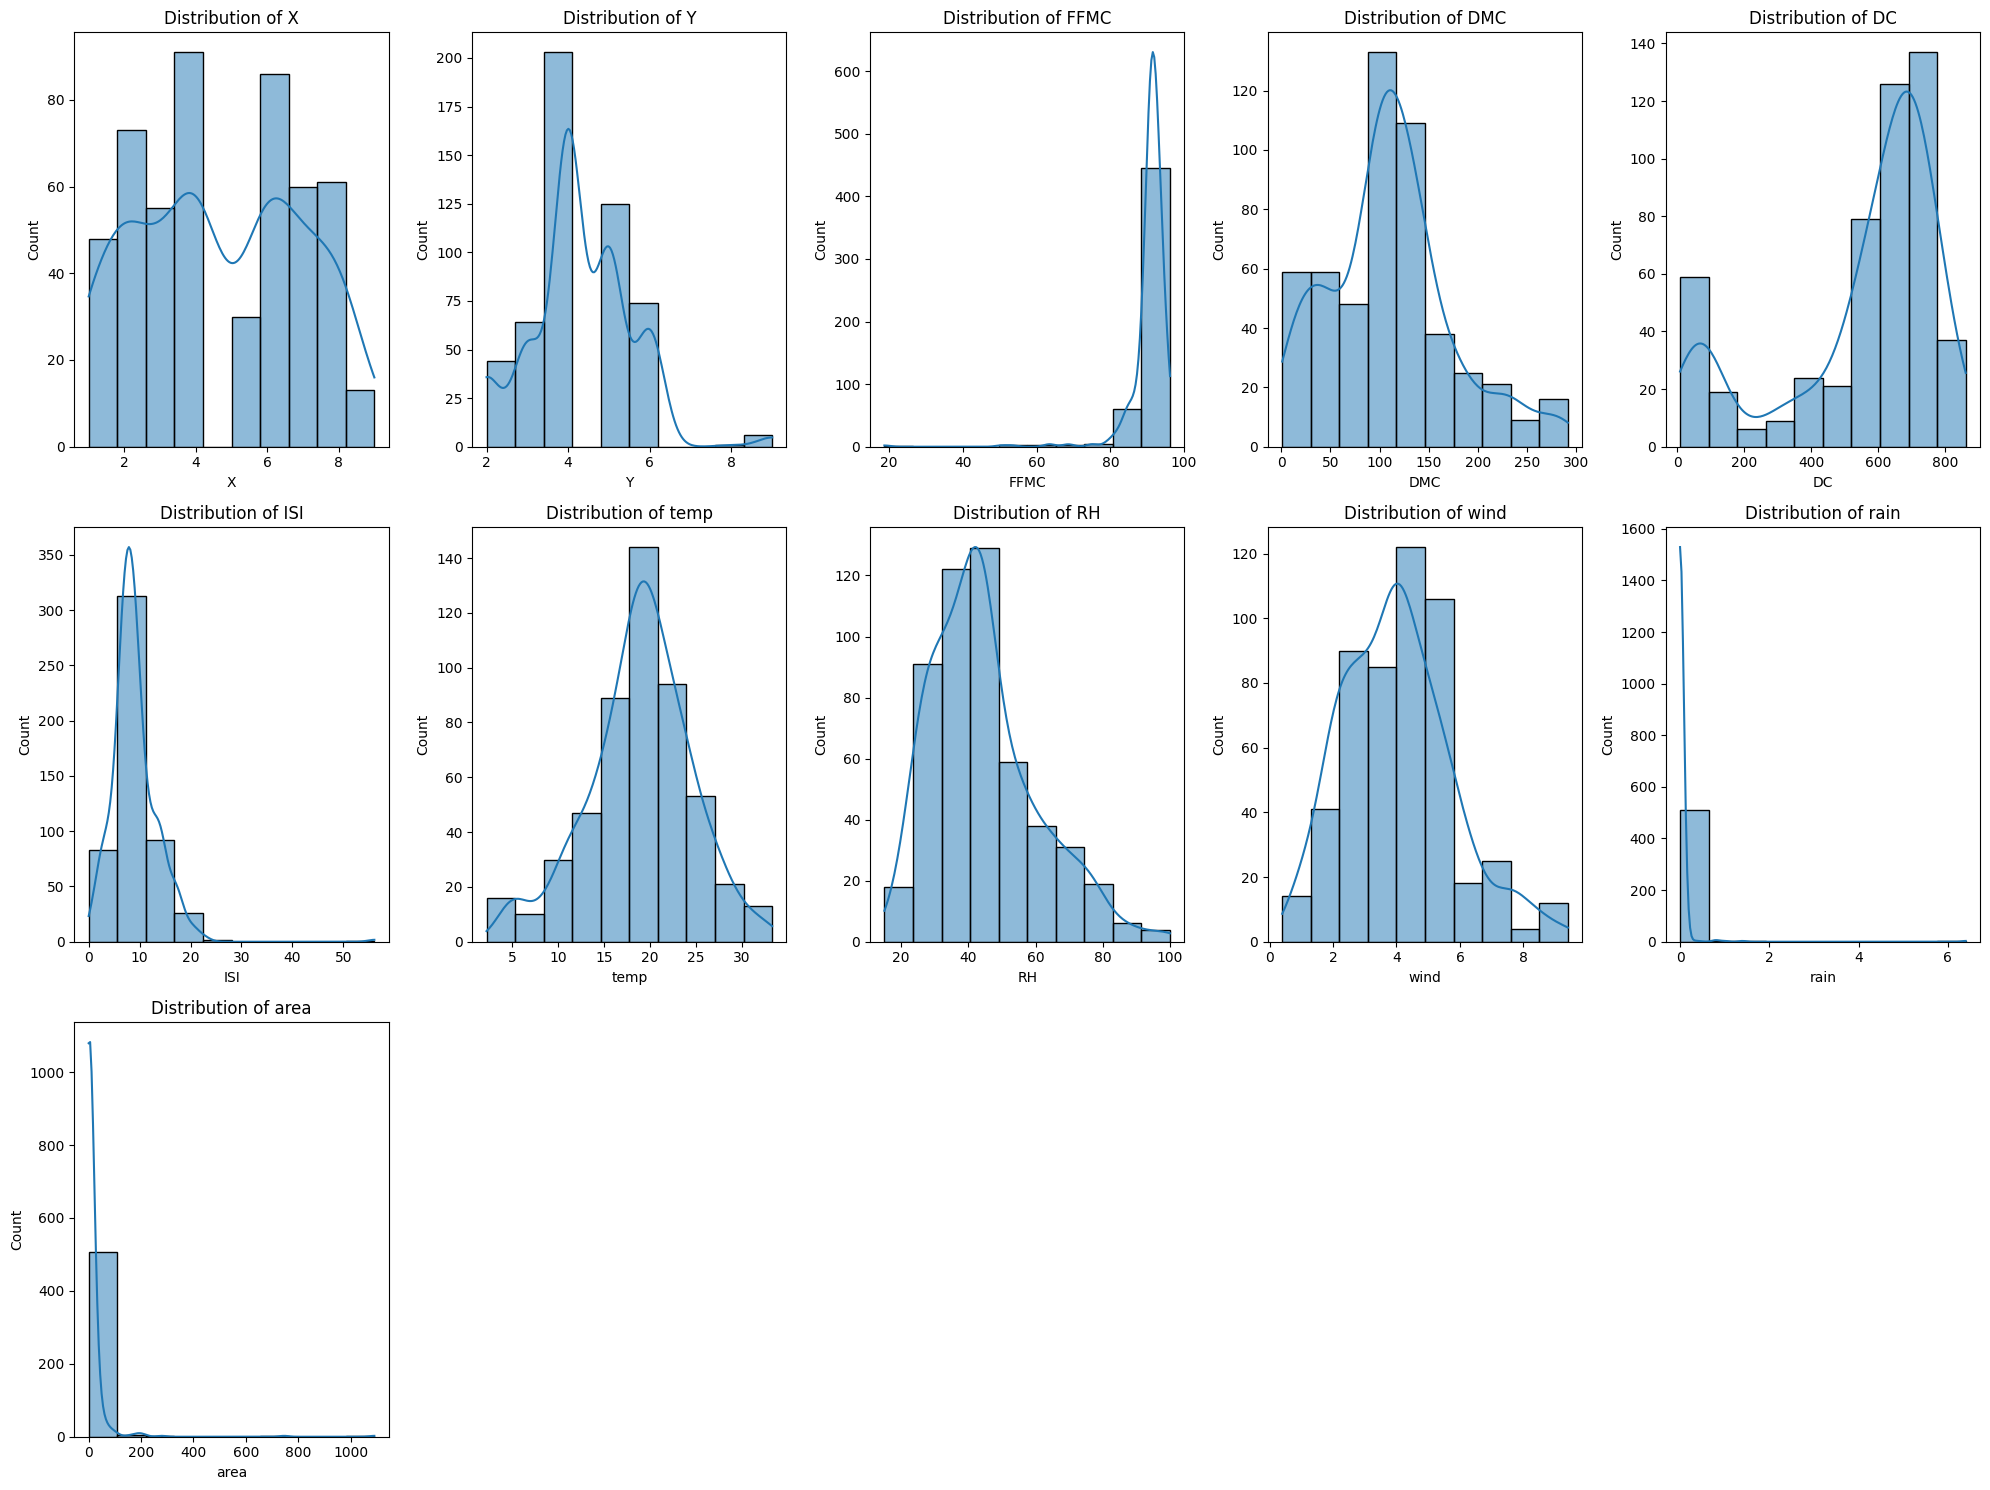

In [13]:
distribution_other = fires_clean[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']]

n_rows = 3
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(distribution_other.columns):
    if distribution_other[col].dtype == 'object' or distribution_other[col].nunique() < 6:  # Check for categorical data
        sns.countplot(data=distribution_other, x=col, ax=axes[i])
    else:
        sns.histplot(data=distribution_other, x=col, ax=axes[i], bins=10, kde=True)

    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

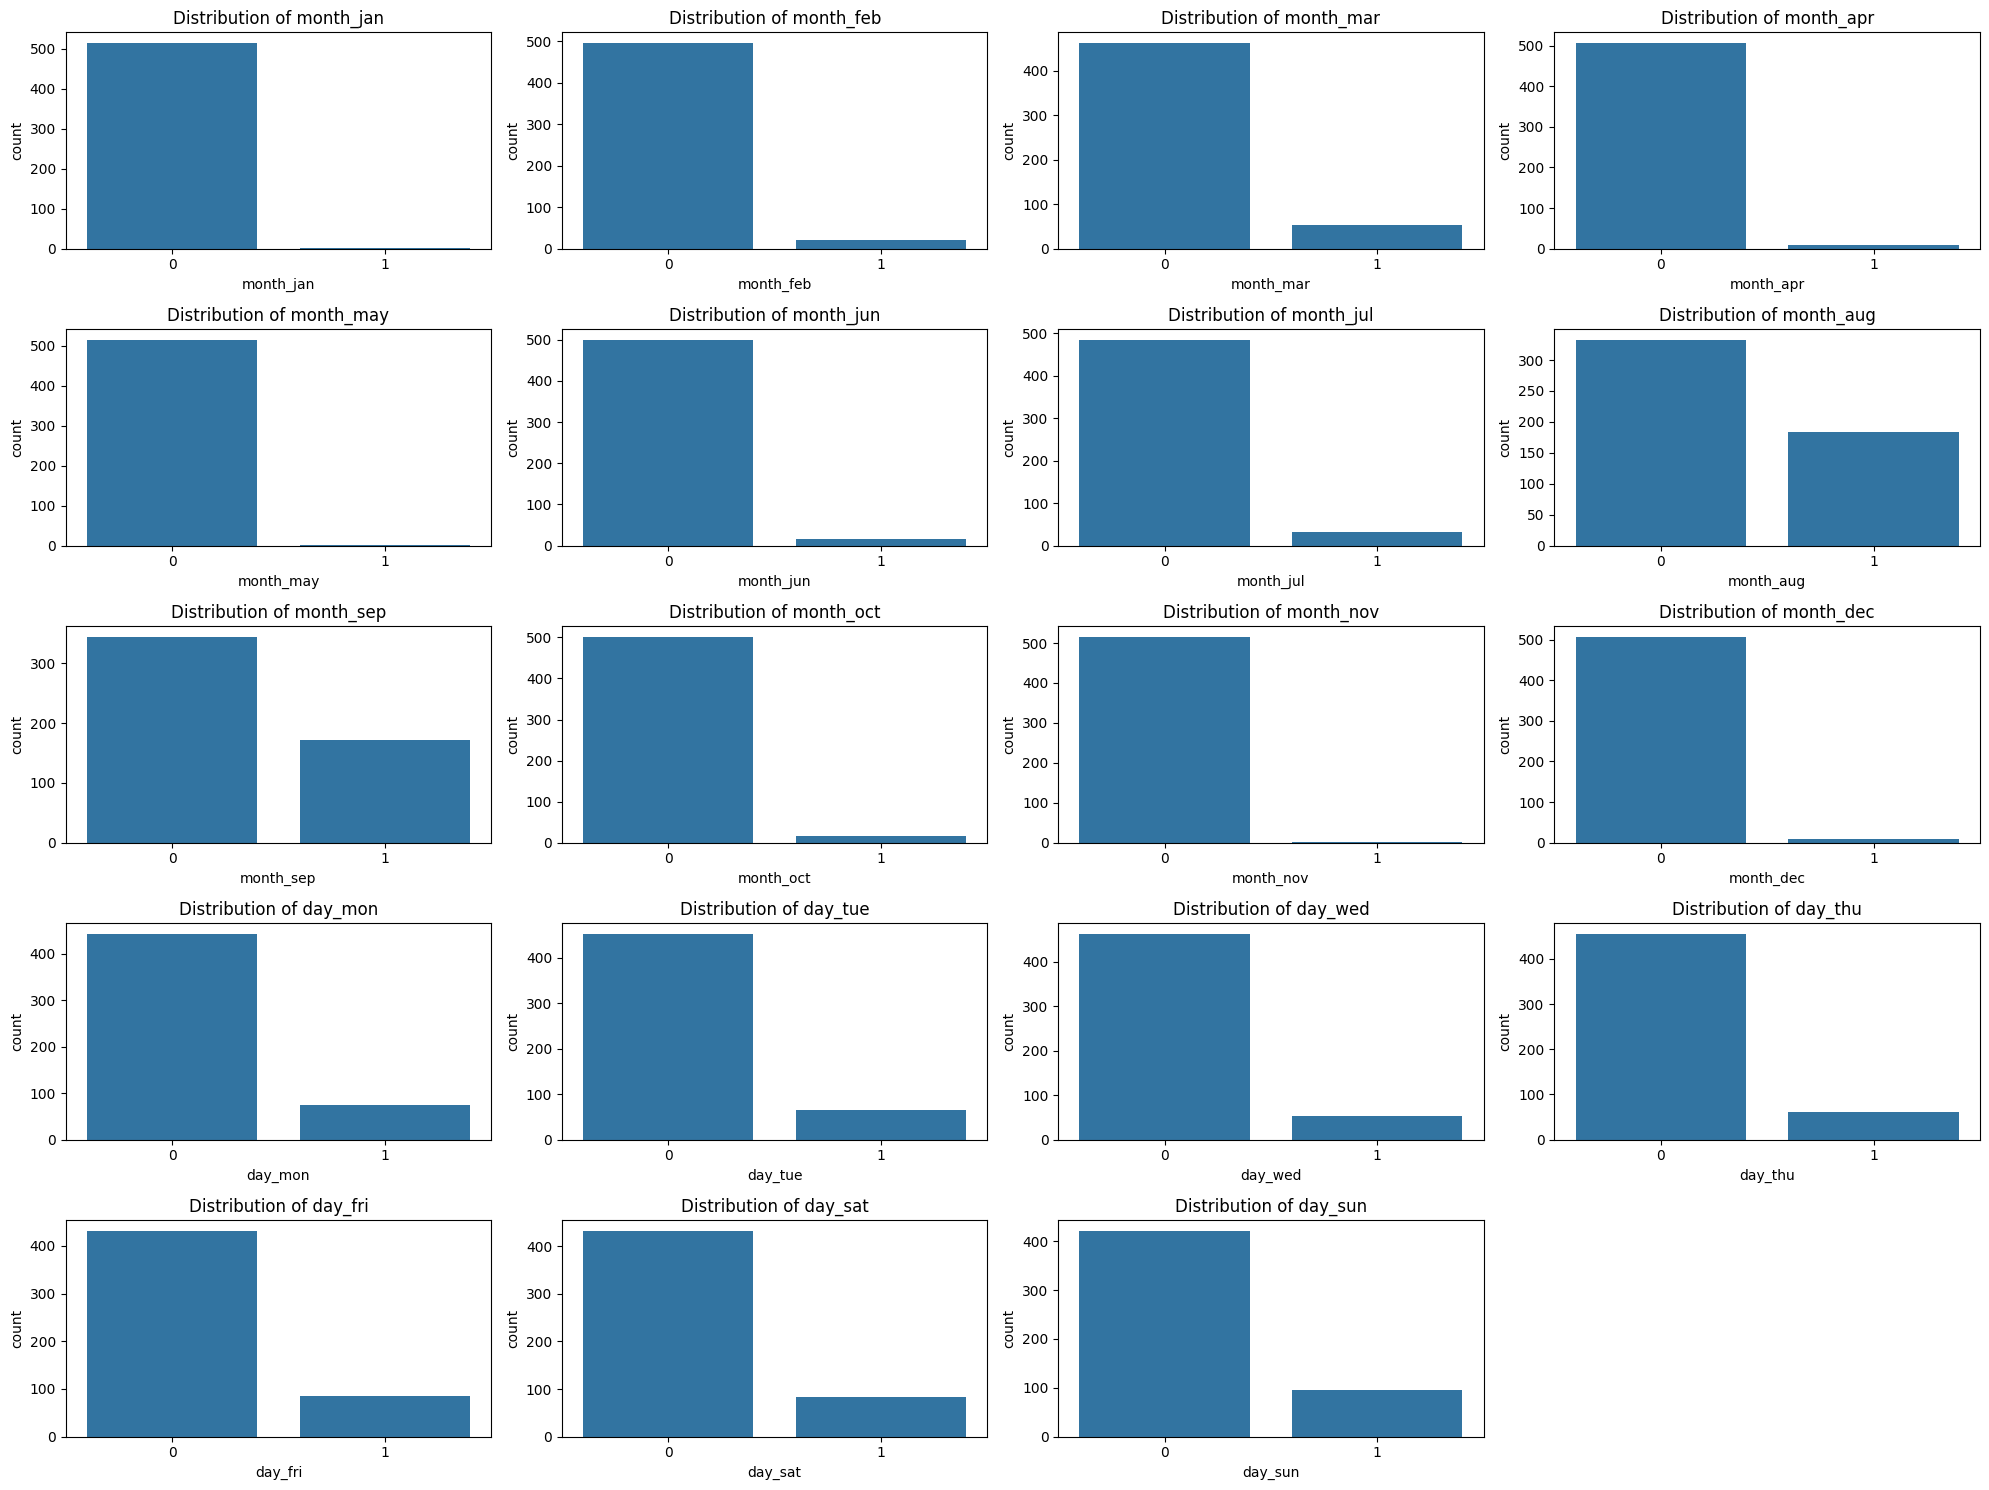

In [14]:
distribution_dv = fires_clean.drop(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area'], axis = 1)

n_rows = 5
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(distribution_dv.columns):
    if distribution_dv[col].dtype == 'object' or distribution_dv[col].nunique() < 6:  # Check for categorical data
        sns.countplot(data=distribution_dv, x=col, ax=axes[i])
    else:
        sns.histplot(data=distribution_dv, x=col, ax=axes[i], bins=10, kde=True)

    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [15]:
model = LinearRegression()